In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from glob import glob

In [2]:
from sklearn.model_selection import train_test_split
from sklearn import metrics

In [3]:
import cv2
import gc
import os

In [4]:
import tensorflow as tf
from tensorflow import keras
from keras import layers

In [5]:
import warnings
warnings.filterwarnings('ignore')

In [6]:

from zipfile import ZipFile
# Path to the zip file
data_path = r'C:\Users\Kushagra Gupta\Downloads\archive (1).zip'

# Extract the zip file to a known directory
extract_to = r'C:\Users\Kushagra Gupta\Downloads\extracted'
with ZipFile(data_path, 'r') as zip:
    zip.extractall(extract_to)
    print('The data set has been extracted.')

# Set the correct path to the extracted data
path = r'C:\Users\Kushagra Gupta\Downloads\extracted\lung_colon_image_set\lung_image_sets'
classes = os.listdir(path)
print(classes)

The data set has been extracted.
['lung_aca', 'lung_n', 'lung_scc']


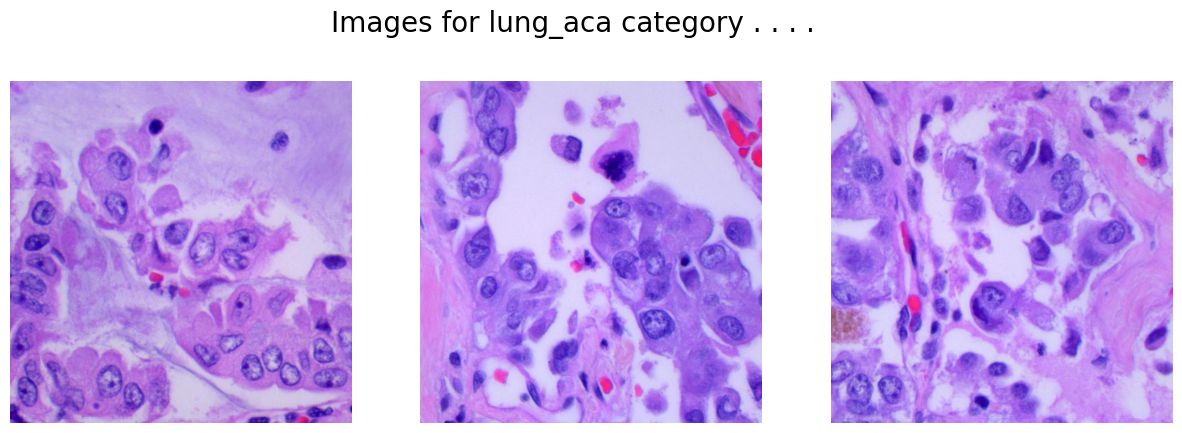

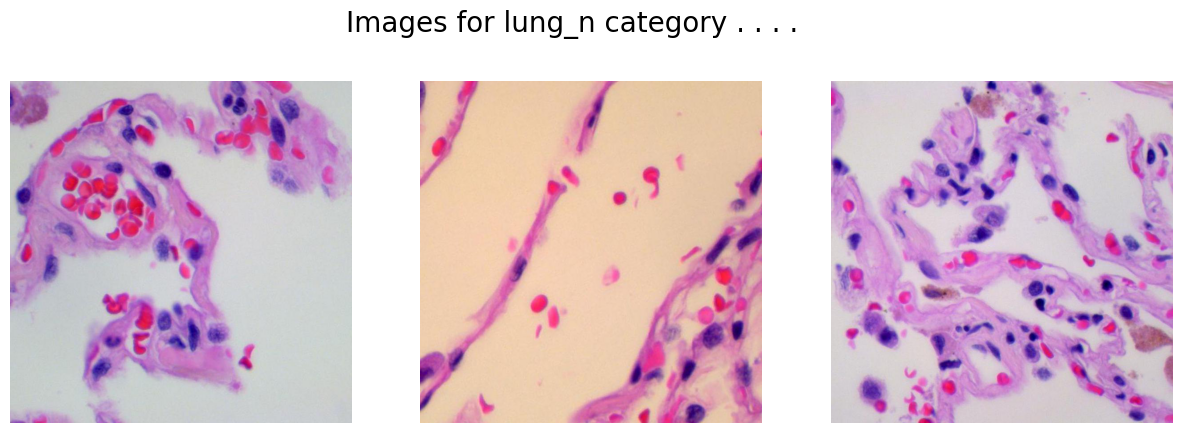

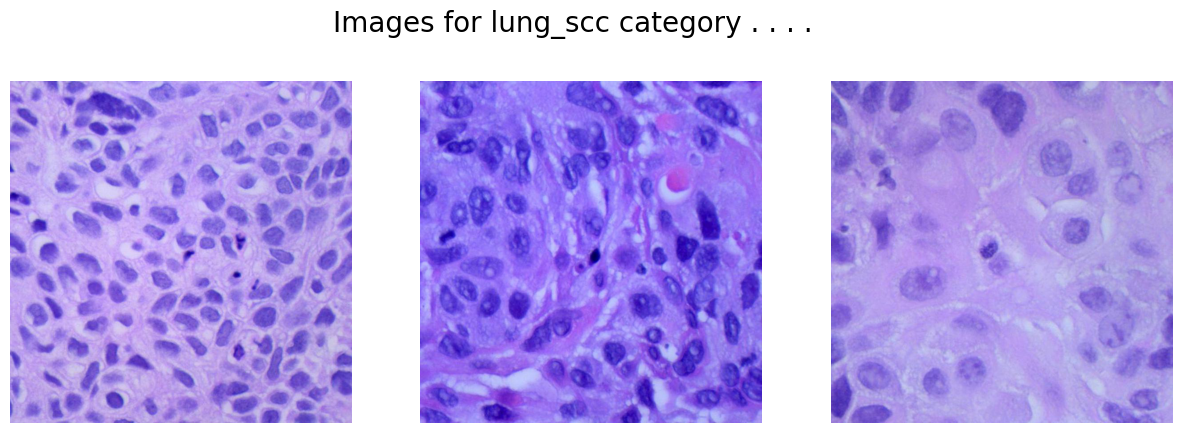

In [7]:
for cat in classes:
    image_dir = f'{path}/{cat}'
    images = os.listdir(image_dir)

    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    fig.suptitle(f'Images for {cat} category . . . .', fontsize=20)

    for i in range(3):
        k = np.random.randint(0, len(images))
        img = np.array(Image.open(f'{path}/{cat}/{images[k]}'))
        ax[i].imshow(img)
        ax[i].axis('off')
    plt.show()


In [8]:
IMG_SIZE = 256
SPLIT = 0.2
EPOCHS = 10
BATCH_SIZE = 64



In [9]:
X = []
Y = []

for i, cat in enumerate(classes):
  images = glob(f'{path}/{cat}/*.jpeg')
 
  for image in images:
    img = cv2.imread(image)
     
    X.append(cv2.resize(img, (IMG_SIZE, IMG_SIZE)))
    Y.append(i)
 
X = np.asarray(X)
one_hot_encoded_Y = pd.get_dummies(Y).values

In [10]:
X_train, X_val, Y_train, Y_val = train_test_split(X, one_hot_encoded_Y,
test_size = SPLIT,
random_state = 2022)
print(X_train.shape, X_val.shape)


(12000, 256, 256, 3) (3000, 256, 256, 3)


In [11]:
# model = keras.models.Sequential([
#     layers.Conv2D(filters=32,
#                 kernel_size=(5, 5),
#                 activation='relu',
#                 input_shape=(IMG_SIZE,
#                             IMG_SIZE,
#                             3),
#                 padding='same'),
#     layers.MaxPooling2D(2, 2),

#     layers.Conv2D(filters=64,
#                 kernel_size=(3, 3),
#                 activation='relu',
#                 padding='same'),
#     layers.MaxPooling2D(2, 2),

#     layers.Conv2D(filters=128,
#                 kernel_size=(3, 3),
#                 activation='relu',
#                 padding='same'),
#     layers.MaxPooling2D(2, 2),

#     layers.Flatten(),
#     layers.Dense(256, activation='relu'),
#     layers.BatchNormalization(),
#     layers.Dense(128, activation='relu'),
#     layers.Dropout(0.3),
#     layers.BatchNormalization(),
#     layers.Dense(3, activation='softmax')
# ])


In [12]:
# model.summary()

In [13]:

# model.compile(
#     optimizer = 'adam',
#     loss = 'categorical_crossentropy',
#     metrics = ['accuracy']
# )

In [14]:
# from keras.callbacks import EarlyStopping, ReduceLROnPlateau


# class myCallback(tf.keras.callbacks.Callback):
#     def on_epoch_end(self, epoch, logs={}):
#         if logs.get('val_accuracy') > 0.90:
#             print('\n Validation accuracy has reached upto \
#                     90% so, stopping further training.')
#             self.model.stop_training = True


# es = EarlyStopping(patience=3,
#                 monitor='val_accuracy',
#                 restore_best_weights=True)

# lr = ReduceLROnPlateau(monitor='val_loss',
#                     patience=2,
#                     factor=0.5,
#                     verbose=1)



In [15]:

# history = model.fit(X_train, Y_train,
#                     validation_data = (X_val, Y_val),
#                     batch_size = BATCH_SIZE,
#                     epochs = EPOCHS,
#                     verbose = 1,
#                     callbacks = [es, lr, myCallback()])

In [16]:
# history_df = pd.DataFrame(history.history)
# history_df.loc[:,['loss','val_loss']].plot()
# history_df.loc[:,['accuracy','val_accuracy']].plot()
# plt.show()


In [17]:
# Y_pred = model.predict(X_val)
# Y_val = np.argmax(Y_val, axis=1)
# Y_pred = np.argmax(Y_pred, axis=1)


In [18]:
# print(metrics.classification_report(Y_val, Y_pred,
#                                     target_names=classes))


In [19]:
## improvement starts

In [20]:
def conv_block(input_tensor, num_filters):
    x = layers.Conv2D(num_filters, (3, 3), padding='same', kernel_regularizer=keras.regularizers.l2(0.001))(input_tensor)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    return x

def residual_block(input_tensor, num_filters):
    x = conv_block(input_tensor, num_filters)
    x = conv_block(x, num_filters)
    
    # Match the input tensor channels to the output channels
    if input_tensor.shape[-1] != num_filters:
        input_tensor = layers.Conv2D(num_filters, (1, 1), padding='same', kernel_regularizer=keras.regularizers.l2(0.001))(input_tensor)
    
    x = layers.Add()([x, input_tensor])
    return x

In [21]:
input_shape = (IMG_SIZE, IMG_SIZE, 3)
inputs = keras.Input(shape=input_shape)

In [22]:
x = conv_block(inputs, 32)
x = conv_block(x, 32)
x = layers.MaxPooling2D((2, 2))(x)

x = residual_block(x, 64)
x = layers.MaxPooling2D((2, 2))(x)

x = residual_block(x, 128)
x = layers.MaxPooling2D((2, 2))(x)

x = residual_block(x, 256)
x = layers.MaxPooling2D((2, 2))(x)

x = layers.Flatten()(x)
x = layers.Dense(256, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001))(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.5)(x)

x = layers.Dense(128, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001))(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.5)(x)

In [23]:
outputs = layers.Dense(3, activation='softmax')(x)


In [24]:
model = keras.Model(inputs, outputs)
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 256, 256, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d (Conv2D)               │ (None, 256, 256, 32)      │             896 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization           │ (None, 256, 256, 32)      │             128 │ conv2d[0][0]               │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ re_lu (ReLU)                  │ (None, 256, 256, 32)      │               0 │ batch_normalization[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_1 (Conv2D)             │ (None, 256, 256, 32)      │           9,248 │ re_lu[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_1         │ (None, 256, 256, 32)      │             128 │ conv2d_1[0][0]             │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ re_lu_1 (ReLU)                │ (None, 256, 256, 32)      │               0 │ batch_normalization_1[0][… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d (MaxPooling2D)  │ (None, 128, 128, 32)      │               0 │ re_lu_1[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_2 (Conv2D)             │ (None, 128, 128, 64)      │          18,496 │ max_pooling2d[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_2         │ (None, 128, 128, 64)      │             256 │ conv2d_2[0][0]             │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ re_lu_2 (ReLU)                │ (None, 128, 128, 64)      │               0 │ batch_normalization_2[0][… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_3 (Conv2D)             │ (None, 128, 128, 64)      │          36,928 │ re_lu_2[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_3         │ (None, 128, 128, 64)      │             256 │ conv2d_3[0][0]             │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ re_lu_3 (ReLU)                │ (None, 128, 128, 64)      │               0 │ batch_normalization_3[0][… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_4 (Conv2D)             │ (None, 128, 128, 64)      │           2,112 │ max_pooling2d[0][0]        │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 18,031,843 (68.79 MB)

 Trainable params: 18,029,155 (68.78 MB)

 Non-trainable params: 2,688 (10.50 KB)

In [25]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [26]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('val_accuracy') > 0.90:
            print('\n Validation accuracy has reached 90%, stopping further training.')
            self.model.stop_training = True

es = EarlyStopping(patience=3, monitor='val_accuracy', restore_best_weights=True)
lr = ReduceLROnPlateau(monitor='val_loss', patience=2, factor=0.5, verbose=1)

In [ ]:
history = model.fit(
    X_train, Y_train,
    validation_data=(X_val, Y_val),
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    verbose=1,
    callbacks=[lr]
)

Epoch 1/10
149/188 ━━━━━━━━━━━━━━━━━━━━ 13:07 20s/step - accuracy: 0.8157 - loss: 2.5216

In [ ]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot()
history_df.loc[:, ['accuracy', 'val_accuracy']].plot()
plt.show()

In [ ]:
Y_pred = model.predict(X_val)
Y_val = np.argmax(Y_val, axis=1)
Y_pred = np.argmax(Y_pred, axis=1)

In [ ]:
print(metrics.classification_report(Y_val, Y_pred, target_names=classes))

In [ ]:

##now also doing k cross validation
##P.S: got very bad results

In [32]:
IMG_SIZE = 128
EPOCHS = 10
BATCH_SIZE = 32
N_FOLDS = 5  # Number of folds for K-fold cross-validation

X = []
Y = []

for i, cat in enumerate(classes):
    images = glob(f'{path}/{cat}/*.jpeg')
    for image in images:
        img = cv2.imread(image)
        X.append(cv2.resize(img, (IMG_SIZE, IMG_SIZE)))
        Y.append(i)

X = np.asarray(X)
one_hot_encoded_Y = pd.get_dummies(Y).values

In [33]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=N_FOLDS, shuffle=True, random_state=2022)
fold_no = 1
accuracies = []

Training fold 1...


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_11 (Conv2D)  │ (None, 128, 128,  │        448 │ input_layer_1[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │         64 │ conv2d_11[0][0]   │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_8 (ReLU)      │ (None, 128, 128,  │          0 │ batch_normalizat… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_12 (Conv2D)  │ (None, 128, 128,  │      2,320 │ re_lu_8[0][0]     │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │         64 │ conv2d_12[0][0]   │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_9 (ReLU)      │ (None, 128, 128,  │          0 │ batch_normalizat… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 64, 64,    │          0 │ re_lu_9[0][0]     │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_13 (Conv2D)  │ (None, 64, 64,    │      4,640 │ max_pooling2d_4[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        128 │ conv2d_13[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_10 (ReLU)     │ (None, 64, 64,    │          0 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_14 (Conv2D)  │ (None, 64, 64,    │      9,248 │ re_lu_10[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        128 │ conv2d_14[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_11 (ReLU)     │ (None, 64, 64,    │          0 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_15 (Conv2D)  │ (None, 64, 64,    │        544 │ max_pooling2d_4[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_3 (Add)         │ (None, 64, 64,    │          0 │ re_lu_11[0][0],   │
│                     │ 32)               │            │ conv2d_15[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 32, 32,    │          0 │ add_3[0][0]     

 Total params: 2,182,131 (8.32 MB)

 Trainable params: 2,181,299 (8.32 MB)

 Non-trainable params: 832 (3.25 KB)

Epoch 1/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 158s 390ms/step - accuracy: 0.8071 - loss: 1.0949 - val_accuracy: 0.8677 - val_loss: 0.7765 - learning_rate: 0.0010
Epoch 2/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 165s 441ms/step - accuracy: 0.9064 - loss: 0.7105 - val_accuracy: 0.8220 - val_loss: 0.8922 - learning_rate: 0.0010
Epoch 3/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 446ms/step - accuracy: 0.9331 - loss: 0.5215
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
375/375 ━━━━━━━━━━━━━━━━━━━━ 176s 470ms/step - accuracy: 0.9331 - loss: 0.5214 - val_accuracy: 0.6317 - val_loss: 1.3677 - learning_rate: 0.0010
Epoch 4/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 184s 492ms/step - accuracy: 0.9527 - loss: 0.4091 - val_accuracy: 0.7527 - val_loss: 1.0753 - learning_rate: 5.0000e-04


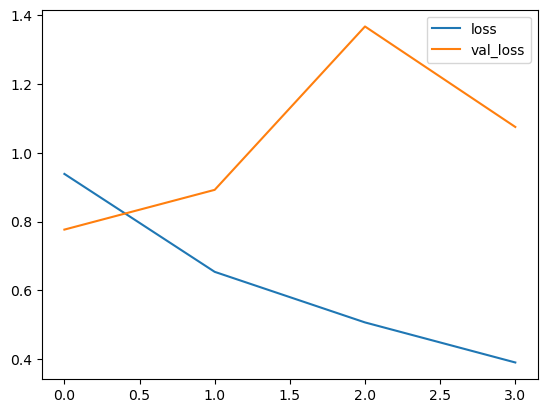

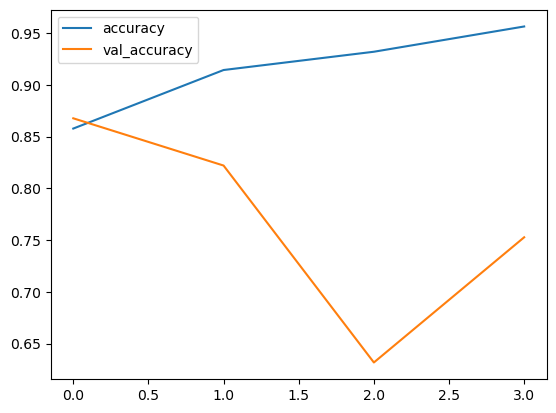

94/94 ━━━━━━━━━━━━━━━━━━━━ 11s 113ms/step
              precision    recall  f1-score   support

    lung_aca       0.72      0.97      0.83       987
      lung_n       0.98      1.00      0.99       977
    lung_scc       0.98      0.65      0.78      1036

    accuracy                           0.87      3000
   macro avg       0.90      0.87      0.87      3000
weighted avg       0.90      0.87      0.86      3000

Fold 1 Accuracy: 0.8676666666666667
Training fold 2...


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_19 (Conv2D)  │ (None, 128, 128,  │        448 │ input_layer_2[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │         64 │ conv2d_19[0][0]   │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_14 (ReLU)     │ (None, 128, 128,  │          0 │ batch_normalizat… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_20 (Conv2D)  │ (None, 128, 128,  │      2,320 │ re_lu_14[0][0]    │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │         64 │ conv2d_20[0][0]   │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_15 (ReLU)     │ (None, 128, 128,  │          0 │ batch_normalizat… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_7     │ (None, 64, 64,    │          0 │ re_lu_15[0][0]    │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_21 (Conv2D)  │ (None, 64, 64,    │      4,640 │ max_pooling2d_7[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        128 │ conv2d_21[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_16 (ReLU)     │ (None, 64, 64,    │          0 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_22 (Conv2D)  │ (None, 64, 64,    │      9,248 │ re_lu_16[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        128 │ conv2d_22[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_17 (ReLU)     │ (None, 64, 64,    │          0 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_23 (Conv2D)  │ (None, 64, 64,    │        544 │ max_pooling2d_7[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_5 (Add)         │ (None, 64, 64,    │          0 │ re_lu_17[0][0],   │
│                     │ 32)               │            │ conv2d_23[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_8     │ (None, 32, 32,    │          0 │ add_5[0][0]     

 Total params: 2,182,131 (8.32 MB)

 Trainable params: 2,181,299 (8.32 MB)

 Non-trainable params: 832 (3.25 KB)

Epoch 1/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 197s 498ms/step - accuracy: 0.8159 - loss: 1.1282 - val_accuracy: 0.8303 - val_loss: 0.9155 - learning_rate: 0.0010
Epoch 2/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 175s 467ms/step - accuracy: 0.9222 - loss: 0.6812 - val_accuracy: 0.8907 - val_loss: 0.7204 - learning_rate: 0.0010
Epoch 3/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 438ms/step - accuracy: 0.9448 - loss: 0.5143
 Validation accuracy has reached 90%, stopping further training.
375/375 ━━━━━━━━━━━━━━━━━━━━ 173s 462ms/step - accuracy: 0.9448 - loss: 0.5143 - val_accuracy: 0.9270 - val_loss: 0.5161 - learning_rate: 0.0010


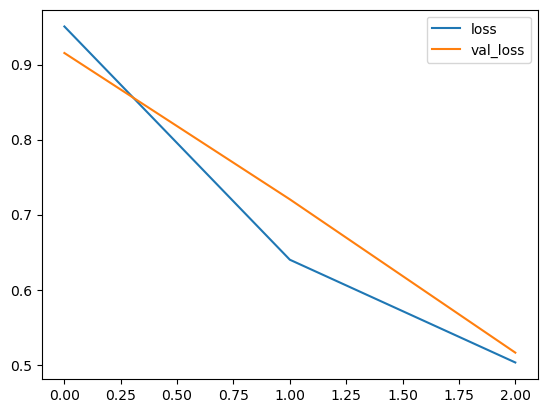

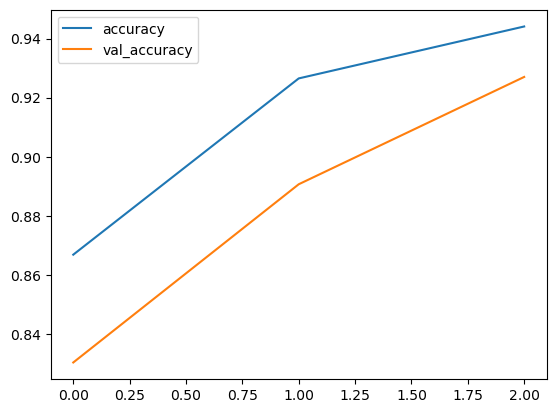

94/94 ━━━━━━━━━━━━━━━━━━━━ 10s 102ms/step
              precision    recall  f1-score   support

    lung_aca       0.91      0.86      0.89       996
      lung_n       1.00      1.00      1.00       981
    lung_scc       0.88      0.92      0.90      1023

    accuracy                           0.93      3000
   macro avg       0.93      0.93      0.93      3000
weighted avg       0.93      0.93      0.93      3000

Fold 2 Accuracy: 0.927
Training fold 3...


Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_27 (Conv2D)  │ (None, 128, 128,  │        448 │ input_layer_3[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │         64 │ conv2d_27[0][0]   │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_20 (ReLU)     │ (None, 128, 128,  │          0 │ batch_normalizat… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_28 (Conv2D)  │ (None, 128, 128,  │      2,320 │ re_lu_20[0][0]    │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │         64 │ conv2d_28[0][0]   │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_21 (ReLU)     │ (None, 128, 128,  │          0 │ batch_normalizat… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_10    │ (None, 64, 64,    │          0 │ re_lu_21[0][0]    │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_29 (Conv2D)  │ (None, 64, 64,    │      4,640 │ max_pooling2d_10… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        128 │ conv2d_29[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_22 (ReLU)     │ (None, 64, 64,    │          0 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_30 (Conv2D)  │ (None, 64, 64,    │      9,248 │ re_lu_22[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        128 │ conv2d_30[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_23 (ReLU)     │ (None, 64, 64,    │          0 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_31 (Conv2D)  │ (None, 64, 64,    │        544 │ max_pooling2d_10… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_7 (Add)         │ (None, 64, 64,    │          0 │ re_lu_23[0][0],   │
│                     │ 32)               │            │ conv2d_31[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_11    │ (None, 32, 32,    │          0 │ add_7[0][0]     

 Total params: 2,182,131 (8.32 MB)

 Trainable params: 2,181,299 (8.32 MB)

 Non-trainable params: 832 (3.25 KB)

Epoch 1/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 206s 514ms/step - accuracy: 0.7759 - loss: 1.1678 - val_accuracy: 0.7487 - val_loss: 1.0906 - learning_rate: 0.0010
Epoch 2/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 232s 619ms/step - accuracy: 0.9016 - loss: 0.6827 - val_accuracy: 0.6580 - val_loss: 1.4727 - learning_rate: 0.0010
Epoch 3/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 234s 624ms/step - accuracy: 0.9366 - loss: 0.4897 - val_accuracy: 0.7980 - val_loss: 0.9509 - learning_rate: 0.0010
Epoch 4/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 581ms/step - accuracy: 0.9510 - loss: 0.4116
 Validation accuracy has reached 90%, stopping further training.
375/375 ━━━━━━━━━━━━━━━━━━━━ 231s 616ms/step - accuracy: 0.9510 - loss: 0.4116 - val_accuracy: 0.9327 - val_loss: 0.5034 - learning_rate: 0.0010


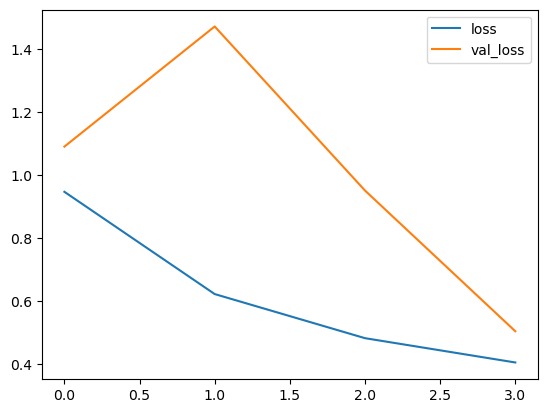

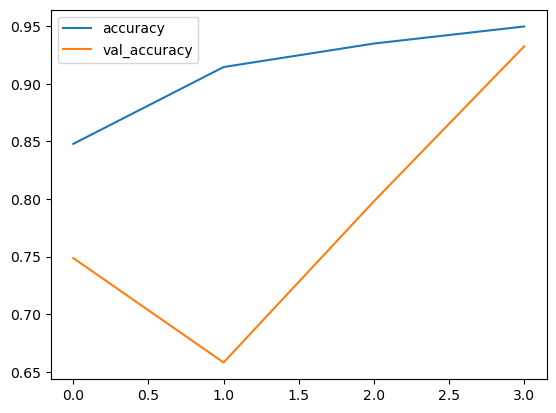

94/94 ━━━━━━━━━━━━━━━━━━━━ 15s 148ms/step
              precision    recall  f1-score   support

    lung_aca       0.86      0.95      0.90      1001
      lung_n       1.00      0.94      0.97      1035
    lung_scc       0.94      0.91      0.92       964

    accuracy                           0.93      3000
   macro avg       0.94      0.93      0.93      3000
weighted avg       0.94      0.93      0.93      3000

Fold 3 Accuracy: 0.9326666666666666
Training fold 4...


Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_35 (Conv2D)  │ (None, 128, 128,  │        448 │ input_layer_4[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │         64 │ conv2d_35[0][0]   │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_26 (ReLU)     │ (None, 128, 128,  │          0 │ batch_normalizat… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_36 (Conv2D)  │ (None, 128, 128,  │      2,320 │ re_lu_26[0][0]    │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │         64 │ conv2d_36[0][0]   │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_27 (ReLU)     │ (None, 128, 128,  │          0 │ batch_normalizat… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_13    │ (None, 64, 64,    │          0 │ re_lu_27[0][0]    │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_37 (Conv2D)  │ (None, 64, 64,    │      4,640 │ max_pooling2d_13… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        128 │ conv2d_37[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_28 (ReLU)     │ (None, 64, 64,    │          0 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_38 (Conv2D)  │ (None, 64, 64,    │      9,248 │ re_lu_28[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        128 │ conv2d_38[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_29 (ReLU)     │ (None, 64, 64,    │          0 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_39 (Conv2D)  │ (None, 64, 64,    │        544 │ max_pooling2d_13… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_9 (Add)         │ (None, 64, 64,    │          0 │ re_lu_29[0][0],   │
│                     │ 32)               │            │ conv2d_39[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_14    │ (None, 32, 32,    │          0 │ add_9[0][0]     

 Total params: 2,182,131 (8.32 MB)

 Trainable params: 2,181,299 (8.32 MB)

 Non-trainable params: 832 (3.25 KB)

Epoch 1/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 252s 618ms/step - accuracy: 0.8063 - loss: 1.1326 - val_accuracy: 0.5310 - val_loss: 2.3291 - learning_rate: 0.0010
Epoch 2/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 228s 609ms/step - accuracy: 0.9199 - loss: 0.6718 - val_accuracy: 0.8427 - val_loss: 0.7642 - learning_rate: 0.0010
Epoch 3/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 578ms/step - accuracy: 0.9361 - loss: 0.5274
 Validation accuracy has reached 90%, stopping further training.
375/375 ━━━━━━━━━━━━━━━━━━━━ 230s 613ms/step - accuracy: 0.9361 - loss: 0.5273 - val_accuracy: 0.9273 - val_loss: 0.5547 - learning_rate: 0.0010


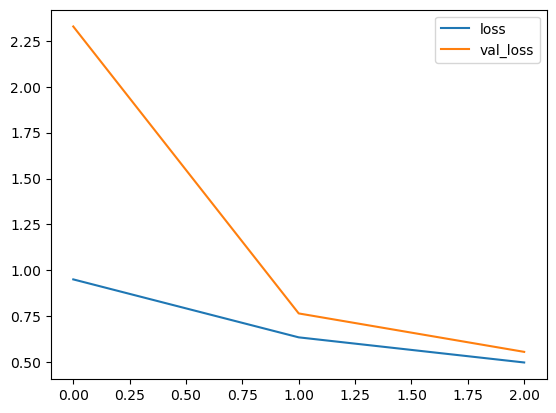

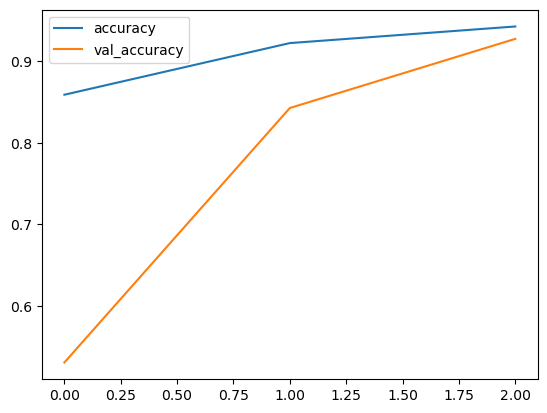

94/94 ━━━━━━━━━━━━━━━━━━━━ 15s 151ms/step
              precision    recall  f1-score   support

    lung_aca       0.89      0.90      0.89      1008
      lung_n       1.00      0.97      0.99      1008
    lung_scc       0.90      0.91      0.90       984

    accuracy                           0.93      3000
   macro avg       0.93      0.93      0.93      3000
weighted avg       0.93      0.93      0.93      3000

Fold 4 Accuracy: 0.9273333333333333
Training fold 5...


Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_43 (Conv2D)  │ (None, 128, 128,  │        448 │ input_layer_5[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │         64 │ conv2d_43[0][0]   │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_32 (ReLU)     │ (None, 128, 128,  │          0 │ batch_normalizat… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_44 (Conv2D)  │ (None, 128, 128,  │      2,320 │ re_lu_32[0][0]    │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │         64 │ conv2d_44[0][0]   │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_33 (ReLU)     │ (None, 128, 128,  │          0 │ batch_normalizat… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_16    │ (None, 64, 64,    │          0 │ re_lu_33[0][0]    │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_45 (Conv2D)  │ (None, 64, 64,    │      4,640 │ max_pooling2d_16… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        128 │ conv2d_45[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_34 (ReLU)     │ (None, 64, 64,    │          0 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_46 (Conv2D)  │ (None, 64, 64,    │      9,248 │ re_lu_34[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        128 │ conv2d_46[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_35 (ReLU)     │ (None, 64, 64,    │          0 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_47 (Conv2D)  │ (None, 64, 64,    │        544 │ max_pooling2d_16… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_11 (Add)        │ (None, 64, 64,    │          0 │ re_lu_35[0][0],   │
│                     │ 32)               │            │ conv2d_47[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_17    │ (None, 32, 32,    │          0 │ add_11[0][0]    

 Total params: 2,182,131 (8.32 MB)

 Trainable params: 2,181,299 (8.32 MB)

 Non-trainable params: 832 (3.25 KB)

Epoch 1/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 585ms/step - accuracy: 0.8083 - loss: 1.1269
 Validation accuracy has reached 90%, stopping further training.
375/375 ━━━━━━━━━━━━━━━━━━━━ 256s 626ms/step - accuracy: 0.8084 - loss: 1.1264 - val_accuracy: 0.9393 - val_loss: 0.6588 - learning_rate: 0.0010


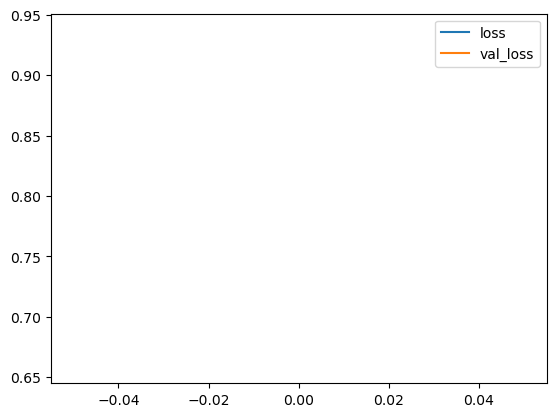

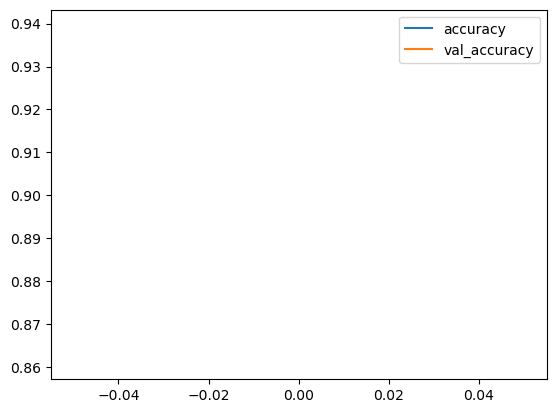

94/94 ━━━━━━━━━━━━━━━━━━━━ 20s 152ms/step
              precision    recall  f1-score   support

    lung_aca       0.94      0.88      0.91      1008
      lung_n       0.98      1.00      0.99       999
    lung_scc       0.90      0.94      0.92       993

    accuracy                           0.94      3000
   macro avg       0.94      0.94      0.94      3000
weighted avg       0.94      0.94      0.94      3000

Fold 5 Accuracy: 0.9393333333333334


In [34]:
for train_index, val_index in kf.split(X):
    print(f'Training fold {fold_no}...')
    X_train, X_val = X[train_index], X[val_index]
    Y_train, Y_val = one_hot_encoded_Y[train_index], one_hot_encoded_Y[val_index]

    def conv_block(input_tensor, num_filters):
        x = layers.Conv2D(num_filters, (3, 3), padding='same', kernel_regularizer=keras.regularizers.l2(0.001))(input_tensor)
        x = layers.BatchNormalization()(x)
        x = layers.ReLU()(x)
        return x

    def residual_block(input_tensor, num_filters):
        x = conv_block(input_tensor, num_filters)
        x = conv_block(x, num_filters)
        
        if input_tensor.shape[-1] != num_filters:
            input_tensor = layers.Conv2D(num_filters, (1, 1), padding='same', kernel_regularizer=keras.regularizers.l2(0.001))(input_tensor)
        
        x = layers.Add()([x, input_tensor])
        return x

    input_shape = (IMG_SIZE, IMG_SIZE, 3)
    inputs = keras.Input(shape=input_shape)

    x = conv_block(inputs, 16)
    x = conv_block(x, 16)
    x = layers.MaxPooling2D((2, 2))(x)

    x = residual_block(x, 32)
    x = layers.MaxPooling2D((2, 2))(x)

    x = residual_block(x, 64)
    x = layers.MaxPooling2D((2, 2))(x)

    x = layers.Flatten()(x)
    x = layers.Dense(128, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)

    x = layers.Dense(64, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)

    outputs = layers.Dense(3, activation='softmax')(x)

    model = keras.Model(inputs, outputs)
    model.summary()

    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    from keras.callbacks import EarlyStopping, ReduceLROnPlateau

    class myCallback(tf.keras.callbacks.Callback):
        def on_epoch_end(self, epoch, logs={}):
            if logs.get('val_accuracy') > 0.90:
                print('\n Validation accuracy has reached 90%, stopping further training.')
                self.model.stop_training = True

    es = EarlyStopping(patience=3, monitor='val_accuracy', restore_best_weights=True)
    lr = ReduceLROnPlateau(monitor='val_loss', patience=2, factor=0.5, verbose=1)

    history = model.fit(
        X_train, Y_train,
        validation_data=(X_val, Y_val),
        batch_size=BATCH_SIZE,
        epochs=EPOCHS,
        verbose=1,
        callbacks=[es, lr, myCallback()]
    )

    history_df = pd.DataFrame(history.history)
    history_df.loc[:, ['loss', 'val_loss']].plot()
    history_df.loc[:, ['accuracy', 'val_accuracy']].plot()
    plt.show()

    Y_pred = model.predict(X_val)
    Y_val = np.argmax(Y_val, axis=1)
    Y_pred = np.argmax(Y_pred, axis=1)

    print(metrics.classification_report(Y_val, Y_pred, target_names=classes))
    accuracy = metrics.accuracy_score(Y_val, Y_pred)
    accuracies.append(accuracy)
    print(f'Fold {fold_no} Accuracy: {accuracy}')
    fold_no += 1


In [35]:
print(f'Average accuracy across {N_FOLDS} folds: {np.mean(accuracies)}')


Average accuracy across 5 folds: 0.9187999999999998
